References: https://github.com/ageron/tf2_course/tree/main

# Neural Nets with Keras

Don't hesitate to look at the documentation at [keras.io](https://keras.io/). All the code examples should work fine with tf.keras, the only difference is how to import Keras:

```python
# keras.io code:
from keras.layers import Dense
output_layer = Dense(10)

# corresponding tf.keras code:
from tensorflow.keras.layers import Dense
output_layer = Dense(10)

# or:
from tensorflow import keras
output_layer = keras.layers.Dense(10)
```

In this notebook, we will not use any TensorFlow-specific code, so everything you see would run just the same way on [keras-team](https://github.com/keras-team/keras) or any other Python implementation of the Keras API (except for the imports).

## Imports

In [ ]:
!pip install tensorboard


In [ ]:
%load_ext tensorboard 

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

In [ ]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

In [ ]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

## Image classification with tf.keras

### Load the Fashion MNIST dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
fashion_mnist

In [ ]:

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_train_full.shape , X_test.shape

In [ ]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

The training set contains 55,000 grayscale images, each 28x28 pixels:

In [ ]:
X_train.shape

Each pixel intensity is represented by a uint8 (byte) from 0 to 255:

In [ ]:
X_train[0]

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.show()

In [ ]:
plt.imshow(X_train[0], cmap="binary", interpolation="nearest")
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [ ]:
y_train

Here are the corresponding class names:

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [ ]:
class_names[y_train[0]]

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [ ]:
X_valid.shape

In [ ]:
X_test.shape

Let's take a look at a sample of the images in the dataset:

In [ ]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

This dataset has the same structure as the famous MNIST dataset (which you can load using `keras.datasets.mnist.load_data()`), except the images represent fashion items rather than handwritten digits, and it is much more challenging. A simple linear model can reach 92% accuracy on MNIST, but only 83% on fashion MNIST.

### Build a classification neural network with Keras

### 2.1)
Build a `Sequential` model (`keras.models.Sequential`), without any argument, then and add four layers to it by calling its `add()` method:
  * a `Flatten` layer (`keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
  * a `Dense` layer  (`keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
  * Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
  * A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

### 2.2)
Alternatively, you can pass a list containing the 4 layers to the constructor of the `Sequential` model. The model's `layers` attribute holds the list of layers.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.layers

### 2.3)
Call the model's `summary()` method and examine the output. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture. Alternatively, you can uncomment the following code to display the image within Jupyter.

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [ ]:
from IPython.display import SVG
SVG(keras.utils.model_to_dot(model, show_shapes=True).create(prog="dot", format="svg"))

### 2.4)
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `keras.optimizers.SGD(lr=1e-3)` optimizer (stochastic gradient descent with learning rate of 1e-3). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate = 1e-3),
              metrics=["accuracy"])

### 2.5)
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

### 2.6)
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

In [47]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)#plt.gca() retrieves the current axes of the plot, and set_ylim(0, 1) sets the y-axis limits from 0 to 1.
    plt.show()

In [ ]:
plot_learning_curves(history)

### 2.7)
Try running `model.fit()` again, and notice that training continues where it left off.

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

### 2.8)
Call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

In [ ]:
model.evaluate(X_test, y_test)

### 2.9)
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

In [ ]:
n_new = 10
X_new = X_test[:n_new]
y_proba = model.predict(X_new)
y_proba.round(2)

### 2.10)
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

In [ ]:
y_pred = y_proba.argmax(axis=1)
y_pred

### 2.11)
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

In [ ]:
y_proba.max(axis=1).round(2)

### 2.12)
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

In [ ]:
y_proba.round(3)

In [ ]:
np.argsort(-y_proba, axis=1)#sort them in descending order

In [ ]:
k = 3
top_k = np.argsort(-y_proba, axis=1)[:, :k]
top_k

## Scale the features

### 3.1)
When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

In [ ]:
pixel_means = X_train.mean(axis = 0)
pixel_stds = X_train.std(axis = 0)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
X_train.shape

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(1e-3), metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.evaluate(X_test_scaled, y_test)

### 3.2)
Plot the learning curves. Do they look better than earlier?

In [ ]:
plot_learning_curves(history)

## Use Callbacks

### 4.1)
The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [ ]:
root_logdir = "/kaggle/working/"

In [ ]:
%reload_ext tensorboard

In [ ]:
#!kill 1289

In [ ]:
%tensorboard --logdir {root_logdir}


In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(1e-3), metrics=["accuracy"])

In [ ]:
logdir = os.path.join(root_logdir, "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("my_mnist_model.keras", save_best_only=True),
]
history = model.fit(X_train_scaled, y_train, epochs=50,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=callbacks)

### 4.2)
Done

### 4.3)
The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

In [ ]:
model = keras.models.load_model("my_mnist_model.keras")

In [ ]:
model.evaluate(X_valid_scaled, y_valid)

### 4.4)
Look at the list of available callbacks at https://keras.io/callbacks/

# A neural net for regression

### 5.1)
Load the California housing dataset using `sklearn.datasets.fetch_california_housing`. This returns an object with a `DESCR` attribute describing the dataset, a `data` attribute with the input features, and a `target` attribute with the labels. The goal is to predict the price of houses in a district (a census block) given some stats about that district. This is a regression task (predicting values).

In [9]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [ ]:
housing

In [ ]:
print(housing.DESCR)

In [ ]:
housing.feature_names

In [ ]:
housing.data.shape

In [ ]:
housing.target.shape

### 5.2)
Split the dataset into a training set, a validation set and a test set using Scikit-Learn's `sklearn.model_selection.train_test_split()` function.

In [10]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target,test_size = 0.2 , random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [ ]:
len(X_train), len(X_valid), len(X_test)

### 5.3)
Scale the input features (e.g., using a `sklearn.preprocessing.StandardScaler`). Once again, don't forget that you should not fit the validation set or the test set, only the training set.

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### 5.4)
Now build, train and evaluate a neural network to tackle this problem. Then use it to make predictions on the test set.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience=10)]
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_valid_scaled, y_valid), epochs=100,
                    callbacks=callbacks)

In [ ]:
model.evaluate(X_test_scaled, y_test)

In [ ]:
model.predict(X_test_scaled)

In [ ]:
plot_learning_curves(history)

## Hyperparameter search

### 6.1)
Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.

In [ ]:
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for learning_rate in learning_rates:
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_valid_scaled, y_valid), epochs=100,
                        callbacks=callbacks)
    histories.append(history)

In [ ]:
for learning_rate, history in zip(learning_rates, histories):
    print("Learning rate:", learning_rate)
    plot_learning_curves(history)

# The functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer, as shown on the following diagram:

### 7.1)
Use Keras' functional API to implement a Wide & Deep network to tackle the California housing problem.

In [12]:
input = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

In [13]:
model = keras.models.Model(inputs=[input], outputs=[output])

In [14]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │        270 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,239 (4.84 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7118 - val_loss: 0.8605
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7787 - val_loss: 0.7356
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6957 - val_loss: 0.6777
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6406 - val_loss: 0.6444
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6265 - val_loss: 0.6102
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5939 - val_loss: 0.5952
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5859 - val_loss: 0.5717
Epoch 8/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5680 - val_loss: 0.5515
Epoch 9/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5312 - val_loss: 0.5391
Epoch 10/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5484 - val_loss: 0.5335


In [17]:
model.evaluate(X_test_scaled, y_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5363


0.5431506633758545

In [18]:
model.predict(X_test_scaled)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[0.65351295],
       [1.4418421 ],
       [2.6878462 ],
       ...,
       [4.568241  ],
       [0.9113696 ],
       [1.8545074 ]], dtype=float32)

### 7.2)
After the Sequential API and the Functional API, let's try the Subclassing API:
* Create a subclass of the `keras.models.Model` class.
* Create all the layers you need in the constructor (e.g., `self.hidden1 = keras.layers.Dense(...)`).
* Use the layers to process the `input` in the `call()` method, and return the output.
* Note that you do not need to create a `keras.layers.Input` in this case.
* Also note that `self.output` is used by Keras, so you should use another name for the output layer (e.g., `self.output_layer`).

In [19]:
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden1 = keras.layers.Dense(30, activation="relu")
        self.hidden2 = keras.layers.Dense(30, activation="relu")
        self.output_ = keras.layers.Dense(1)

    def call(self, input):
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [20]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(1e-3))

In [21]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3030 - val_loss: 0.8377
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7263 - val_loss: 0.6675
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5961 - val_loss: 0.6209
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5919 - val_loss: 0.5858
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5669 - val_loss: 0.5597
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5365 - val_loss: 0.5399
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5179 - val_loss: 0.5256
Epoch 8/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5180 - val_loss: 0.5121
Epoch 9/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4971 - val_loss: 0.5032
Epoch 10/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4842 - val_loss: 0.4920


In [22]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ ?                      │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,241 (4.85 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [23]:
model.evaluate(X_test_scaled, y_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4973


0.5034230351448059

In [24]:
model.predict(X_test_scaled)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[0.6250496 ],
       [1.4710997 ],
       [3.0472283 ],
       ...,
       [4.432784  ],
       [0.97515815],
       [1.854893  ]], dtype=float32)

### 7.3)
Now suppose you want to send only features 0 to 4 directly to the output, and only features 2 to 7 through the hidden layers, as shown on the diagram. Use the functional API to build, train and evaluate this model.

In [25]:
input_A = keras.layers.Input(shape=[5])
input_B = keras.layers.Input(shape=[6])

In [26]:
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)

In [27]:
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [28]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(1e-3))

In [29]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 30)        │        210 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 30)        │        930 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 35)        │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         36 │ concatenate_6[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,176 (4.59 KB)

 Trainable params: 1,176 (4.59 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
X_train_scaled_A = X_train_scaled[:, :5]
X_train_scaled_B = X_train_scaled[:, 2:]
X_valid_scaled_A = X_valid_scaled[:, :5]
X_valid_scaled_B = X_valid_scaled[:, 2:]
X_test_scaled_A = X_test_scaled[:, :5]
X_test_scaled_B = X_test_scaled[:, 2:]

In [31]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], y_train, epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], y_valid))

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9924 - val_loss: 1.0126
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8457 - val_loss: 0.7719
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7214 - val_loss: 0.7044
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6545 - val_loss: 0.6735
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6239 - val_loss: 0.6449
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6139 - val_loss: 0.6234
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6229 - val_loss: 0.6045
Epoch 8/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5629 - val_loss: 0.5925
Epoch 9/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5673 - val_loss: 0.5784
Epoch 10/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5544 - val_loss: 0.5658


In [32]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], y_test)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5754


0.5803429484367371

In [33]:
model.predict([X_test_scaled_A, X_test_scaled_B])

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0.680542 ],
       [1.3636414],
       [2.4761083],
       ...,
       [4.4306326],
       [1.203906 ],
       [1.8175716]], dtype=float32)

### 7.4)
Build the multi-input and multi-output neural net represented in the diagram.

In [34]:
input_A = keras.layers.Input(shape=X_train_scaled_A.shape[1:])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)

In [35]:
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [36]:
model.compile(loss="mean_squared_error", loss_weights=[0.9, 0.1],
              optimizer=keras.optimizers.SGD(1e-3))

In [37]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 30)        │        210 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 30)        │        930 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 35)        │          0 │ input_layer_3[0]… │
│ (Concatenate)       │                   │            │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         36 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         31 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,207 (4.71 KB)

 Trainable params: 1,207 (4.71 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], [y_train, y_train], epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], [y_valid, y_valid]))

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5621 - val_loss: 1.3882
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1897 - val_loss: 1.0054
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9079 - val_loss: 0.8977
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8052 - val_loss: 0.8402
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7610 - val_loss: 0.7992
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7515 - val_loss: 0.7663
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7113 - val_loss: 0.7345
Epoch 8/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7003 - val_loss: 0.7090
Epoch 9/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6827 - val_loss: 0.6875
Epoch 10/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6711 - val_loss: 0.6727


In [39]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], [y_test, y_test])

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6617


0.6640269756317139

In [40]:
y_pred, y_pred_aux = model.predict([X_test_scaled_A, X_test_scaled_B])

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [41]:
y_pred

array([[0.79291815],
       [1.2428936 ],
       [2.6160724 ],
       ...,
       [4.3530326 ],
       [1.2785895 ],
       [1.8524396 ]], dtype=float32)

In [42]:
y_pred_aux

array([[1.279042 ],
       [1.4484558],
       [1.9924227],
       ...,
       [1.9177079],
       [1.2666099],
       [1.9158762]], dtype=float32)

## Deep Nets

Let's go back to Fashion MNIST and build deep nets to tackle it. We need to load it, split it and scale it.

In [43]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

### 8.1)
Build a sequential model with 20 hidden dense layers, with 100 neurons each, using the ReLU activation function, plus the output layer (10 neurons, softmax activation function). Try to train it for 10 epochs on Fashion MNIST and plot the learning curves. Notice that progress is very slow.

In [45]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,410 (1.04 MB)

 Trainable params: 271,410 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:

history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.1102 - loss: 2.3023 - val_accuracy: 0.1594 - val_loss: 2.3015
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.1317 - loss: 2.3013 - val_accuracy: 0.1596 - val_loss: 2.3006
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.1697 - loss: 2.3002 - val_accuracy: 0.2044 - val_loss: 2.2986
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2392 - loss: 2.2976 - val_accuracy: 0.2406 - val_loss: 2.2932
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.2356 - loss: 2.2905 - val_accuracy: 0.2144 - val_loss: 2.2781
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2039 - loss: 2.2703 - val_accuracy: 0.2014 - val_loss: 2.2279
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.1955 - loss: 2.1762 - val_accuracy: 0.1966 - val_loss: 1.8926
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.1988 - loss: 1.8458 

NameError: name 'plot_learning_curves' is not defined

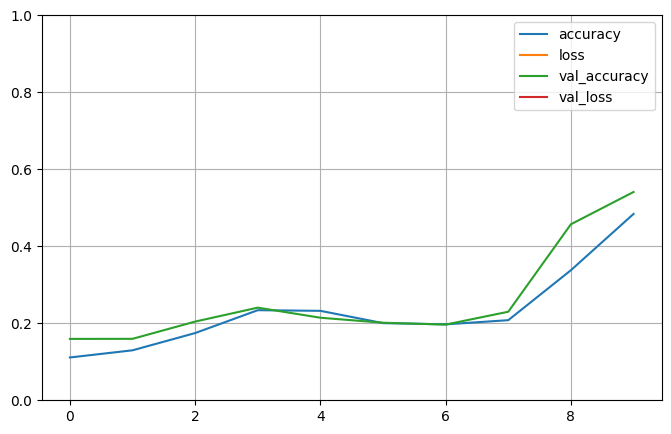

In [48]:
plot_learning_curves(history)

### 8.2)
Update the model to add a `BatchNormalization` layer after every hidden layer. Notice that performance progresses much faster per epoch, although computations are much more intensive. Display the model summary and notice all the non-trainable parameters (the scale $\gamma$ and offset $\beta$ parameters).

In [49]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 279,410 (1.07 MB)

 Trainable params: 275,410 (1.05 MB)

 Non-trainable params: 4,000 (15.62 KB)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.2299 - loss: 2.3762 - val_accuracy: 0.6424 - val_loss: 1.0359
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.5996 - loss: 1.1571 - val_accuracy: 0.7298 - val_loss: 0.7600
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.6644 - loss: 0.9713 - val_accuracy: 0.7570 - val_loss: 0.6662
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6936 - loss: 0.8760 - val_accuracy: 0.7790 - val_loss: 0.6133
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7139 - loss: 0.8225 - val_accuracy: 0.7880 - val_loss: 0.5861
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7286 - loss: 0.7730 - val_accuracy: 0.7986 - val_loss: 0.5543
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7384 - loss: 0.7402 - val_accuracy: 0.8072 - val_loss: 0.5312
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.7485 -

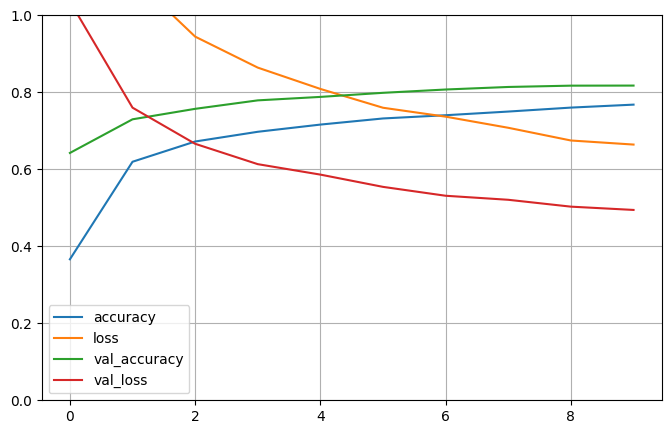

In [50]:

history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [51]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 279,412 (1.07 MB)

 Trainable params: 275,410 (1.05 MB)

 Non-trainable params: 4,000 (15.62 KB)

 Optimizer params: 2 (12.00 B)

### 8.3)
Try moving the BN layers before the hidden layers' activation functions. Does this affect the model's performance?

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.1723 - loss: 2.3940 - val_accuracy: 0.5800 - val_loss: 1.3739
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.5507 - loss: 1.3792 - val_accuracy: 0.7246 - val_loss: 0.8369
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.6585 - loss: 1.0237 - val_accuracy: 0.7590 - val_loss: 0.7041
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.6937 - loss: 0.9023 - val_accuracy: 0.7808 - val_loss: 0.6344
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.7190 - loss: 0.8254 - val_accuracy: 0.7938 - val_loss: 0.5890
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.7343 - loss: 0.7727 - val_accuracy: 0.8062 - val_loss: 0.5525
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7451 - loss: 0.7401 - val_accuracy: 0.8194 - val_loss: 0.5209
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7680 -

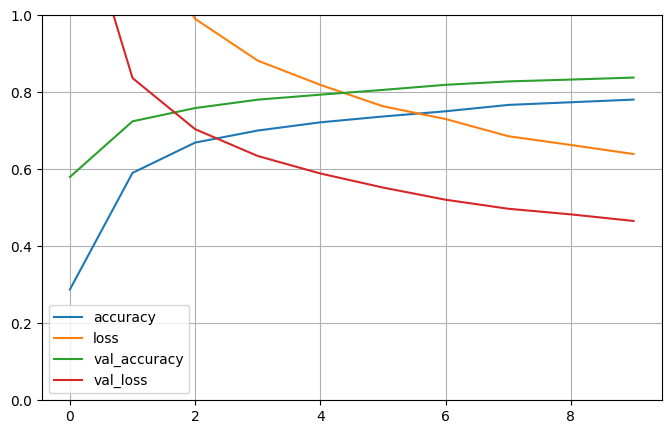

In [52]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.4)
Remove all the BN layers, and just use the SELU activation function instead (always use SELU with LeCun Normal weight initialization). Notice that you get better performance than with BN but training is much faster. Isn't it marvelous? :-)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6955 - loss: 0.8780 - val_accuracy: 0.8248 - val_loss: 0.4970
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8315 - loss: 0.4654 - val_accuracy: 0.8534 - val_loss: 0.4259
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8555 - loss: 0.4026 - val_accuracy: 0.8592 - val_loss: 0.4030
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8671 - loss: 0.3689 - val_accuracy: 0.8680 - val_loss: 0.3921
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8734 - loss: 0.3476 - val_accuracy: 0.8664 - val_loss: 0.3764
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8841 - loss: 0.3215 - val_accuracy: 0.8658 - val_loss: 0.3723
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8870 - loss: 0.3113 - val_accuracy: 0.8726 - val_loss: 0.3626
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8903 - loss: 0.3026 -

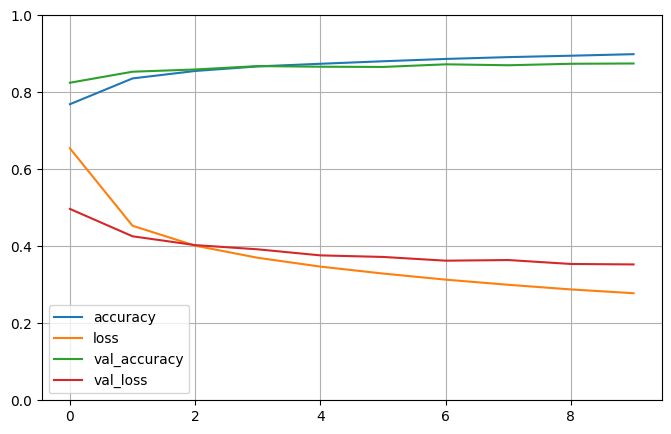

In [53]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.5)
Try training for 10 additional epochs, and notice that the model starts overfitting. Try adding a Dropout layer (with a 50% dropout rate) just before the output layer. Does it reduce overfitting? What about the final validation accuracy?

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9029 - loss: 0.2643 - val_accuracy: 0.8758 - val_loss: 0.3534
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9074 - loss: 0.2569 - val_accuracy: 0.8768 - val_loss: 0.3552
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9093 - loss: 0.2496 - val_accuracy: 0.8748 - val_loss: 0.3556
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9135 - loss: 0.2385 - val_accuracy: 0.8778 - val_loss: 0.3577
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9156 - loss: 0.2332 - val_accuracy: 0.8760 - val_loss: 0.3519
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9179 - loss: 0.2252 - val_accuracy: 0.8760 - val_loss: 0.3538
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9223 - loss: 0.2154 - val_accuracy: 0.8750 - val_loss: 0.3669
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9209 - loss: 0.2163 - 

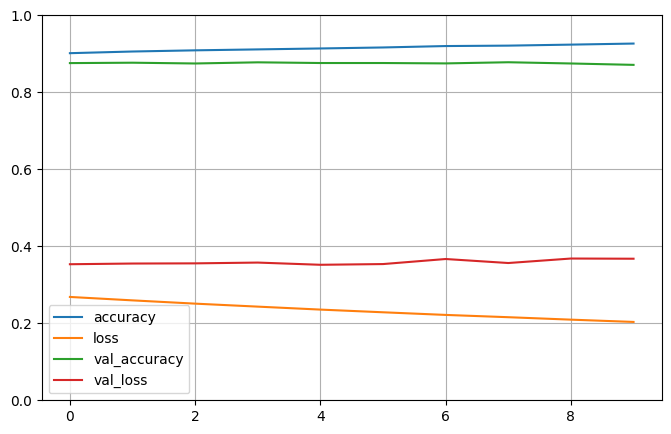

In [54]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6167 - loss: 1.1841 - val_accuracy: 0.8212 - val_loss: 0.5035
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8031 - loss: 0.5821 - val_accuracy: 0.8442 - val_loss: 0.4449
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8344 - loss: 0.4882 - val_accuracy: 0.8532 - val_loss: 0.4127
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8440 - loss: 0.4553 - val_accuracy: 0.8612 - val_loss: 0.3953
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8596 - loss: 0.4123 - val_accuracy: 0.8670 - val_loss: 0.3857
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8692 - loss: 0.3823 - val_accuracy: 0.8686 - val_loss: 0.3788
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8693 - loss: 0.3734 - val_accuracy: 0.8690 - val_loss: 0.3655
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8801 - loss: 0.3497 

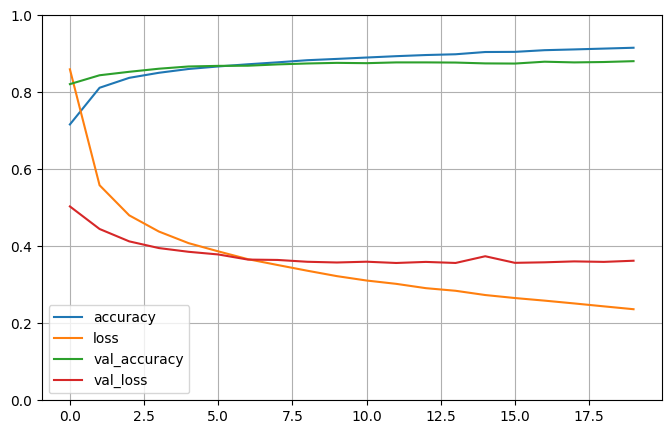

In [57]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)